# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [0]:
#!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2019-12-23 14:30:44--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2019-12-23 14:30:45--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [0]:
device

device(type='cuda', index=0)

# Загружаем данные

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [0]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [0]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        if scheduler is not None:
          scheduler.step()

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

def multiclass_accuracy(prediction, ground_truth):
    return np.mean([p == gt for p, gt in zip(prediction, ground_truth)])
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    val_accuracy = 0
    correct = 0
    total = 0
        
    for i_step, (x, y) in enumerate(loader):
      x_gpu = x.to(device)
      y_gpu = y.to(device)

      pred = model(x_gpu)
      _, indices = torch.max(pred, 1)
      correct += torch.sum(indices == y_gpu)
      total += y_gpu.shape[0]

      val_accuracy = float(correct)/total
    
    return val_accuracy

In [0]:
loss_history, train_history, val_history = \
  train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.405232, Train accuracy: 0.530475, Val accuracy: 0.746911
Average loss: 0.700626, Train accuracy: 0.787650, Val accuracy: 0.797761
Average loss: 0.598498, Train accuracy: 0.821145, Val accuracy: 0.797898
Average loss: 0.552700, Train accuracy: 0.837150, Val accuracy: 0.827179
Average loss: 0.520064, Train accuracy: 0.847234, Val accuracy: 0.797898


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

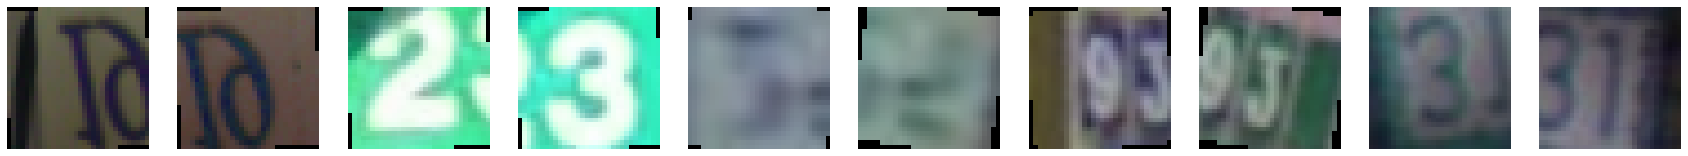

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

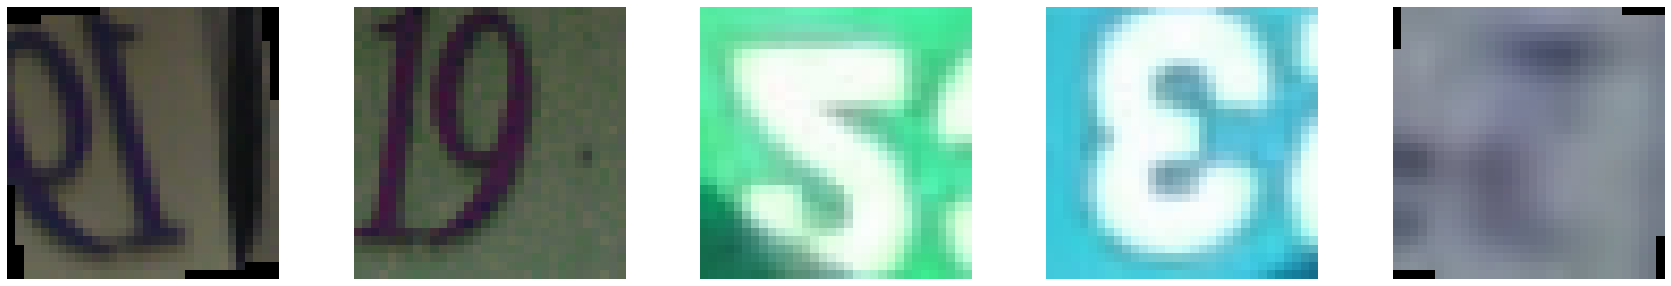

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 5))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 5:
        break
    plt.subplot(1, 5, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])    
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_vis, batch_size=batch_size, sampler=train_sampler)

In [0]:
loss_history, train_history, val_history = \
  train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 1.536486, Train accuracy: 0.466761, Val accuracy: 0.548631
Average loss: 1.295947, Train accuracy: 0.552077, Val accuracy: 0.555047
Average loss: 1.222218, Train accuracy: 0.576920, Val accuracy: 0.601392
Average loss: 1.169515, Train accuracy: 0.598045, Val accuracy: 0.615862
Average loss: 1.133949, Train accuracy: 0.610620, Val accuracy: 0.651833


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [0]:
nn.Conv2d(3, 64, 3, padding=1),
nn.ReLU(inplace=True),
nn.MaxPool2d(4),
nn.Conv2d(64, 64, 3, padding=1),
nn.ReLU(inplace=True),
nn.MaxPool2d(4),    
Flattener(),
nn.Linear(64*2*2, 120)

Linear(in_features=256, out_features=120, bias=True)

In [0]:
lenet_model = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(4),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(4),    
    Flattener(),
    nn.Linear(64*2*2, 120),
    nn.Linear(120, 84),
    nn.Linear(84, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [0]:
# Let's train it!
loss_history, train_history, val_history = \
  train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 2.130941, Train accuracy: 0.234942, Val accuracy: 0.318750
Average loss: 1.650454, Train accuracy: 0.401563, Val accuracy: 0.448024
Average loss: 1.402663, Train accuracy: 0.499369, Val accuracy: 0.489318
Average loss: 1.289492, Train accuracy: 0.544364, Val accuracy: 0.549314
Average loss: 1.221133, Train accuracy: 0.572842, Val accuracy: 0.577230


# Подбор гиперпараметров

In [0]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5] #, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

epoch_num = 5 #10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

for lr in learning_rates:
  for ae in anneal_epochs:
    for r in reg:
      print(f'Parameters are lr={lr}, anneal_epochs={ae}, reg={r}')
      params = Hyperparams(lr, ae, r)

      new_lenet_model = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(4),
          nn.Conv2d(64, 64, 3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(4),    
          Flattener(),
          nn.Linear(64*2*2, 120),
          nn.Linear(120, 84),
          nn.Linear(84, 10),
      )

      new_lenet_model.type(torch.cuda.FloatTensor)
      new_lenet_model.to(device)
      loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
  
      optimizer = optim.Adam(new_lenet_model.parameters(), lr=lr, weight_decay=r)
      step_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=ae, gamma=anneal_coeff)

      loss_history, train_history, val_history = \
        train_model(new_lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler=step_lr)

      results = RunResult(new_lenet_model, train_history, val_history, val_history[-1])
      run_record[params] = results

Parameters are lr=1.0, anneal_epochs=1, reg=0.001
Average loss: 2971461.000000, Train accuracy: 0.112753, Val accuracy: 0.191591
Average loss: 3545.909424, Train accuracy: 0.116968, Val accuracy: 0.115009
Average loss: 907.936462, Train accuracy: 0.118606, Val accuracy: 0.191591
Average loss: 279.754913, Train accuracy: 0.120687, Val accuracy: 0.145519
Average loss: 126.580078, Train accuracy: 0.117394, Val accuracy: 0.068937
Parameters are lr=1.0, anneal_epochs=1, reg=0.0001
Average loss: 606352.937500, Train accuracy: 0.110432, Val accuracy: 0.080609
Average loss: 2198.488037, Train accuracy: 0.115858, Val accuracy: 0.191591
Average loss: 675.851257, Train accuracy: 0.116046, Val accuracy: 0.090779
Average loss: 351.111938, Train accuracy: 0.116541, Val accuracy: 0.099379
Average loss: 277.322540, Train accuracy: 0.117633, Val accuracy: 0.080609
Parameters are lr=1.0, anneal_epochs=1, reg=1e-05
Average loss: 1859188.750000, Train accuracy: 0.125994, Val accuracy: 0.191591
Average los

Зачем мы проверяем на 20-50 эпох, если прогоняем только до 10?)

In [0]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [0]:
epoch_num = 15

new_model = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(4),
          nn.BatchNorm2d(64),
          nn.Conv2d(64, 128, 3, padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(128),
          Flattener(),
          nn.Linear(128*2*2, 120),
          nn.Linear(120, 10),
      )

new_model.type(torch.cuda.FloatTensor)
new_model.to(device)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

optimizer = optim.Adam(new_model.parameters(), lr=1e-2, weight_decay=1e-2)
step_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

loss_history, train_history, val_history = \
  train_model(new_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler=step_lr)

Average loss: 1.990156, Train accuracy: 0.279323, Val accuracy: 0.324892
Average loss: 1.773163, Train accuracy: 0.351756, Val accuracy: 0.386117
Average loss: 1.717432, Train accuracy: 0.379176, Val accuracy: 0.359088
Average loss: 1.695399, Train accuracy: 0.389141, Val accuracy: 0.332878
Average loss: 1.681706, Train accuracy: 0.394055, Val accuracy: 0.380725
Average loss: 1.560787, Train accuracy: 0.444579, Val accuracy: 0.435806
Average loss: 1.498971, Train accuracy: 0.470805, Val accuracy: 0.456624
Average loss: 1.462743, Train accuracy: 0.485275, Val accuracy: 0.472459
Average loss: 1.435267, Train accuracy: 0.493670, Val accuracy: 0.463518
Average loss: 1.418873, Train accuracy: 0.499573, Val accuracy: 0.505221
Average loss: 1.381603, Train accuracy: 0.514657, Val accuracy: 0.507679
Average loss: 1.367208, Train accuracy: 0.519657, Val accuracy: 0.507269
Average loss: 1.366775, Train accuracy: 0.518718, Val accuracy: 0.508088
Average loss: 1.365597, Train accuracy: 0.521329, V

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [0]:
test_loader = torch.utils.data.DataLoader(data_test)

final_test_accuracy = compute_accuracy(new_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.898740012292563
